# IWI Prediction using CLIP Embeddings
In this notebook, we'll use CLIP embeddings derived from satellite images to predict the `IWI` (International Wealth Index) of various locations.


In [26]:
import os
import pandas as pd
import configparser
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import KFold, LeaveOneGroupOut, cross_val_predict, train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

RANDOM_STATE = 42

In [2]:
# Read config file
config = configparser.ConfigParser()
config.read('config.ini')

DATA_DIR = config['PATHS']['DATA_DIR']

embeddings = np.load(os.path.join(DATA_DIR, 'clip_embeddings.npy'))
df = pd.read_csv(os.path.join(DATA_DIR, 'dhs_data.csv'))

assert embeddings.shape[0] == df.shape[0], 'Mismatch between embeddings and metadata rows.'

df

,cluster_id,lon,lat,rural,region_id,country,survey,month,year,iwi
0,AO.Bengo.71.135,13.640789,-8.589805,False,AO.Bengo,Angola,Angola 2015-16 Standard DHS,11,2015,62.334459
1,AO.Bengo.71.158,14.122619,-7.718385,True,AO.Bengo,Angola,Angola 2015-16 Standard DHS,2,2016,8.226589
2,AO.Bengo.71.169,13.654425,-8.592545,False,AO.Bengo,Angola,Angola 2015-16 Standard DHS,10,2015,62.760211
3,AO.Bengo.71.203,13.517859,-8.652260,True,AO.Bengo,Angola,Angola 2015-16 Standard DHS,1,2016,68.211697
4,AO.Bengo.71.208,13.721998,-7.852511,True,AO.Bengo,Angola,Angola 2015-16 Standard DHS,11,2015,14.825944
...,...,...,...,...,...,...,...,...,...,...
69944,ZW.Midlands.72.37,30.008579,-20.911177,True,ZW.Midlands,Zimbabwe,Zimbabwe 2015 Standard DHS,9,2015,27.791567
69945,ZW.Midlands.72.52,29.860028,-20.402214,True,ZW.Midlands,Zimbabwe,Zimbabwe 2015 Standard DHS,10,2015,36.929878
69946,ZW.Midlands.72.69,30.172833,-20.724753,True,ZW.Midlands,Zimbabwe,Zimbabwe 2015 Standard DHS,10,2015,24.406326
69947,ZW.Midlands.72.91,29.820084,-19.453466,False,ZW.Midlands,Zimbabwe,Zimbabwe 2015 Standard DHS,7,2015,59.887344


Rescale embeddings

In [3]:
embeddings_scaler = StandardScaler()
embeddings = embeddings_scaler.fit_transform(embeddings)

## Data exploration

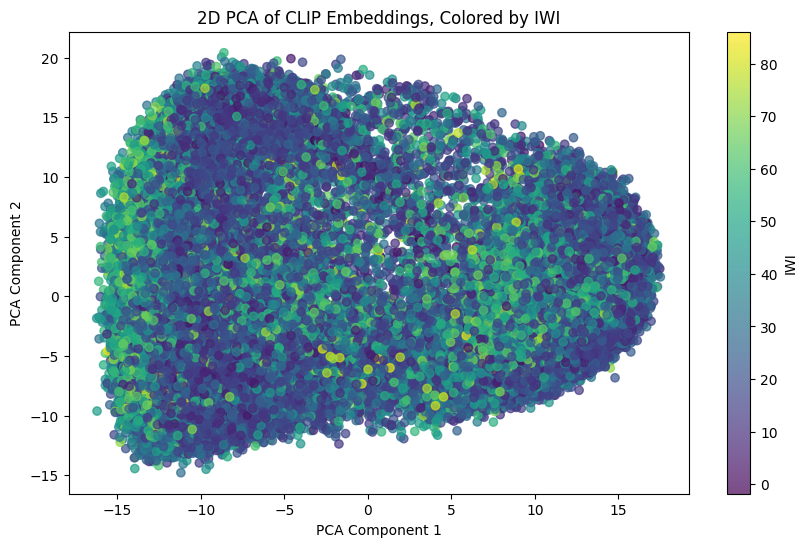

In [4]:
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt

# Reduce the embeddings to 2 principal components for visualization
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings)

# Add PCA components to the DataFrame for easy plotting
df['embedding_pca1'] = embeddings_2d[:, 0]
df['embedding_pca2'] = embeddings_2d[:, 1]

# Plot the first two principal components of the embeddings, colored by IWI
plt.figure(figsize=(10, 6))
sc = plt.scatter(df['embedding_pca1'], df['embedding_pca2'], c=df['iwi'], cmap='viridis', alpha=0.7)
plt.colorbar(sc, label="IWI")
plt.title("2D PCA of CLIP Embeddings, Colored by IWI")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()

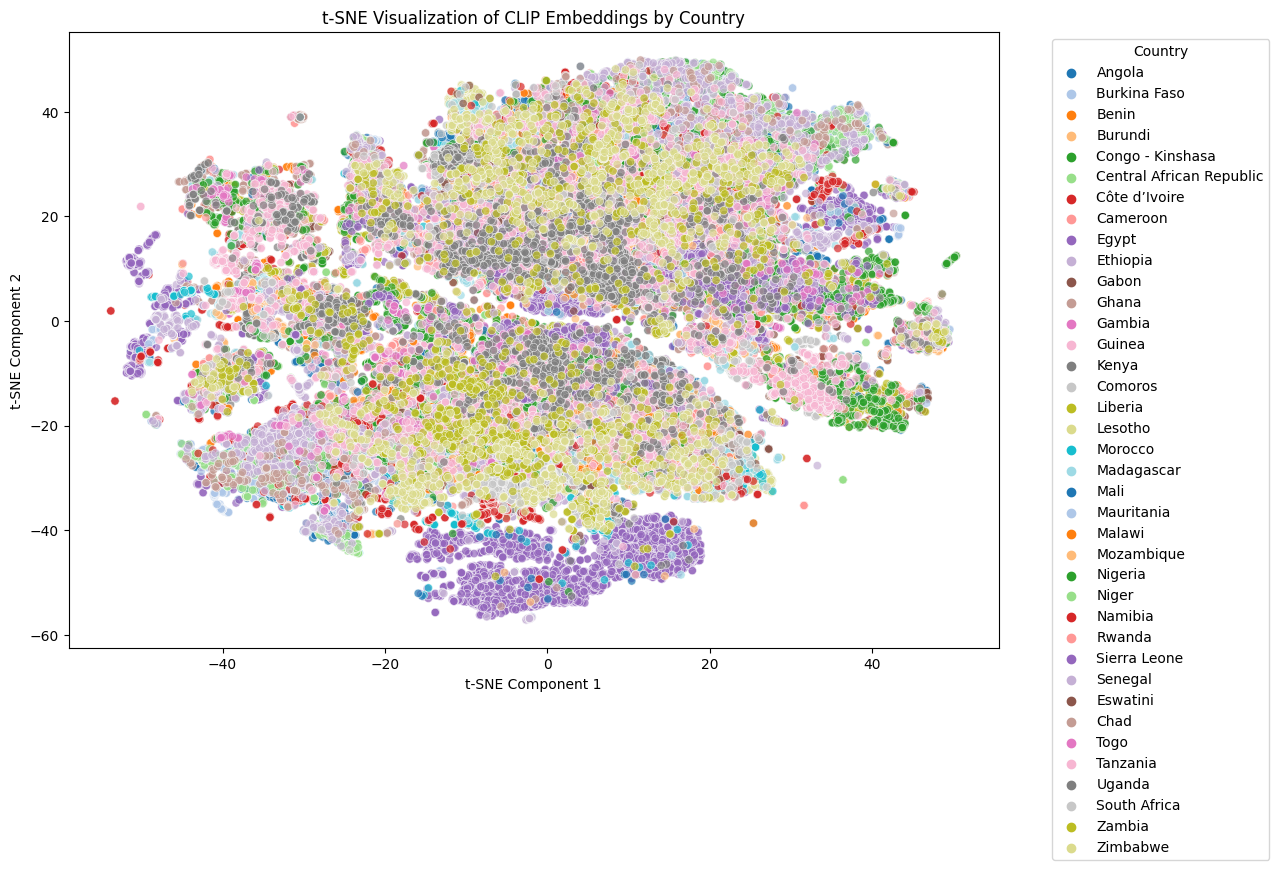

In [5]:
# T-SNE to reduce embeddings to 2D
tsne = TSNE(n_components=2, random_state=RANDOM_STATE)
embeddings_2d = tsne.fit_transform(embeddings)

df['embedding_tsne1'] = embeddings_2d[:, 0]
df['embedding_tsne2'] = embeddings_2d[:, 1]

# Plot the t-SNE embeddings, colored by country
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=df, x='embedding_tsne1', y='embedding_tsne2', 
    hue='country', palette='tab20', alpha=0.7
)
plt.title("t-SNE Visualization of CLIP Embeddings by Country")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend(title="Country", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


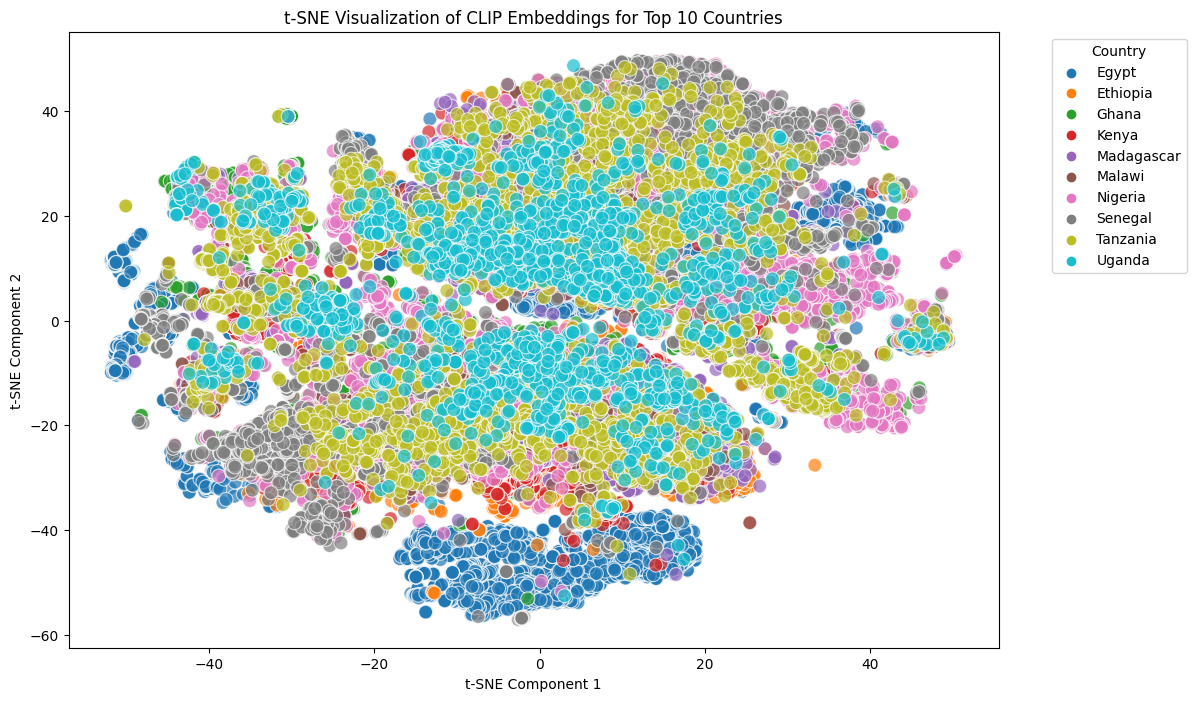

In [6]:
# Get only top 10 countries
top_countries = df['country'].value_counts().head(10).index
df_top_countries = df[df['country'].isin(top_countries)]

# Plot the t-SNE embeddings for just the top 10 countries
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=df_top_countries, x='embedding_tsne1', y='embedding_tsne2',
    hue='country', palette='tab10', alpha=0.7, s=100
)
plt.title("t-SNE Visualization of CLIP Embeddings for Top 10 Countries")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend(title="Country", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


## Feature selection

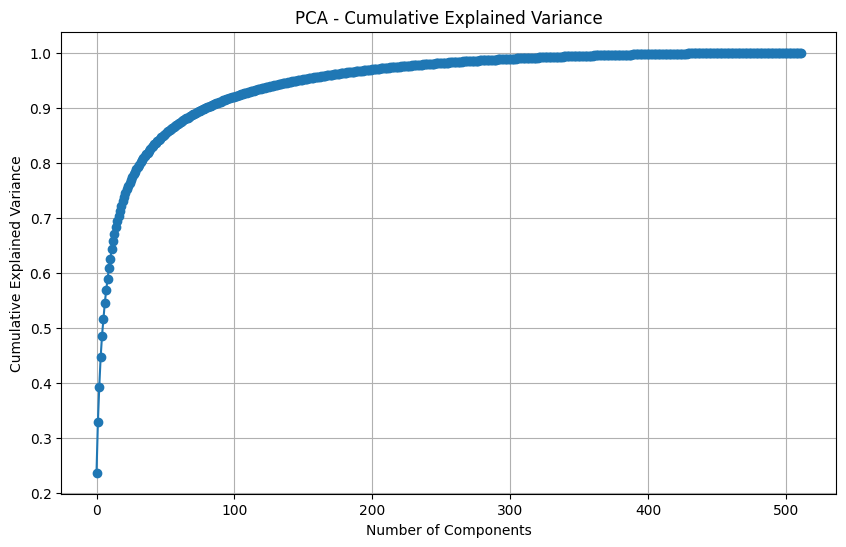

In [7]:
# Do full PCA
pca = PCA()
pca.fit(embeddings)

# Plot the cumulative explained variance to determine the optimal number of components
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
plt.figure(figsize=(10, 6))
plt.plot(cumulative_variance, marker='o')
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA - Cumulative Explained Variance")
plt.grid(True)
plt.show()


In [8]:
# Choose the number of components required to capture 95% of the original variance
n_components = np.argmax(cumulative_variance > 0.95)
pca = PCA(n_components=n_components)
embeddings_reduced = pca.fit_transform(embeddings)

# 'embeddings_reduced' now contains the reduced feature set
print("Reduced embeddings shape:", embeddings_reduced.shape)

Reduced embeddings shape: (69949, 147)


## Train models

In [9]:
# Target variable: `IWI`
X = embeddings_reduced
y = df['iwi'].values / 100.0 # Scale IWI to [0, 1]
countries = df['country']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

Helper function to perform training, hyperparameter tuning, and evaluation

In [ ]:
def train_and_evaluate(model, params, X_train, y_train, X_test, y_test, n_iter=10):
    # RandomSearchCV for cross-validation and hyperparameter tuning
    random_search = RandomizedSearchCV(
        model, params, n_iter=n_iter, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, random_state=RANDOM_STATE
    )
    random_search.fit(X_train, y_train)
    
    # Best estimator and cross-validated score
    best_model = random_search.best_estimator_
    print(f"Best parameters: {random_search.best_params_}")
    
    # Cross-validation score
    cv_score = -random_search.best_score_
    print(f"Cross-validated MSE: {cv_score:.4f}")
    
    # Evaluate on test set
    y_pred = best_model.predict(X_test)
    test_mae = mean_absolute_error(y_test, y_pred)
    test_mse = mean_squared_error(y_test, y_pred)
    test_r2 = r2_score(y_test, y_pred)
    
    print(f"Test MSE: {test_mse:.4f}")
    print(f"Test MAE: {test_mae:.4f}")
    print(f"Test R^2: {test_r2:.4f}\n")
    
    return best_model, test_mae, test_r2

Define the models and hyperparameters to test

In [ ]:
models = {
    'Lasso': {
        'model': Lasso(),
        'params': {
            'alpha': [0.001, 0.01, 0.1, 1, 10, 100]
        }
    },
    'Ridge': {
        'model': Ridge(),
        'params': {
            'alpha': [0.001, 0.01, 0.1, 1, 10, 100]
        }
    },
    'ElasticNet': {
        'model': ElasticNet(),
        'params': {
            'alpha': [0.001, 0.01, 0.1, 1, 10, 100],
            'l1_ratio': [0.1, 0.5, 0.9, 0.99]
        }
    },
    'LightGBM': {
        'model': LGBMRegressor(random_state=RANDOM_STATE),
        'params': {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': [10, 20, 30, -1]
        }
    },
    'XGBoost': {
        'model': XGBRegressor(objective='reg:squarederror', random_state=RANDOM_STATE),
        'params': {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': [3, 6, 10]
        }
    },
    'MLP': {
        'model': MLPRegressor(max_iter=1000, random_state=RANDOM_STATE),
        'params': {
            'hidden_layer_sizes': [(50,), (100,), (100, 50)],
            'alpha': [0.0001, 0.001, 0.01],
            'learning_rate_init': [0.001, 0.01]
        }
    }
}

In [ ]:
results = {}

# Run training and evaluation for each model
for model_name, model_data in models.items():
    print(f"--- {model_name} ---")
    best_model, test_mae, test_r2 = train_and_evaluate(model_data['model'], model_data['params'], X_train, y_train, X_test, y_test)
    
    results[model_name] = {
        'best_model': best_model, 
        'test_mae': test_mae, 
        'test_r2': test_r2
    }

--- Lasso ---


/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_search.py:285: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best parameters: {'alpha': 0.001}
Cross-validated MSE: 0.0192
Test MSE: 0.0195
Test R^2: 0.4620

--- Ridge ---


/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_search.py:285: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best parameters: {'alpha': 100}
Cross-validated MSE: 0.0190
Test MSE: 0.0194
Test R^2: 0.4658

--- ElasticNet ---
Best parameters: {'l1_ratio': 0.1, 'alpha': 0.001}
Cross-validated MSE: 0.0190
Test MSE: 0.0194
Test R^2: 0.4659

--- LightGBM ---
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.054581 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37485
[LightGBM] [Info] Number of data points in the train set: 44767, number of used features: 147
[LightGBM] [Info] Start training from score 0.324016


/opt/conda/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.052035 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37485
[LightGBM] [Info] Number of data points in the train set: 44767, number of used features: 147
[LightGBM] [Info] Start training from score 0.324094
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.052907 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37485
[LightGBM] [Info] Number of data points in the train set: 44767, number of used features: 147
[LightGBM] [Info] Start training from score 0.323969
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046821 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37485
[LightGBM] [Info] Number of data points in the train set: 44768, number of used features: 147
[LightGBM] [Info] Sta

## Results

In [22]:
results

{'Lasso': {'best_model': Lasso(alpha=0.001),
  'test_mse': 0.019529004146884292,
  'test_r2': 0.46204037633825645},
 'Ridge': {'best_model': Ridge(alpha=100),
  'test_mse': 0.01939365088140111,
  'test_r2': 0.46576891217208893},
 'ElasticNet': {'best_model': ElasticNet(alpha=0.001, l1_ratio=0.1),
  'test_mse': 0.01938817163992817,
  'test_r2': 0.46591984719461055},
 'LightGBM': {'best_model': LGBMRegressor(max_depth=20, n_estimators=200, random_state=42),
  'test_mse': 0.017160638991614977,
  'test_r2': 0.5272810213829009},
 'XGBoost': {'best_model': XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
               colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
               early_stopping_rounds=None, enable_categorical=False,
               eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
               importance_type=None, interaction_constraints='',
               learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
               max_delta

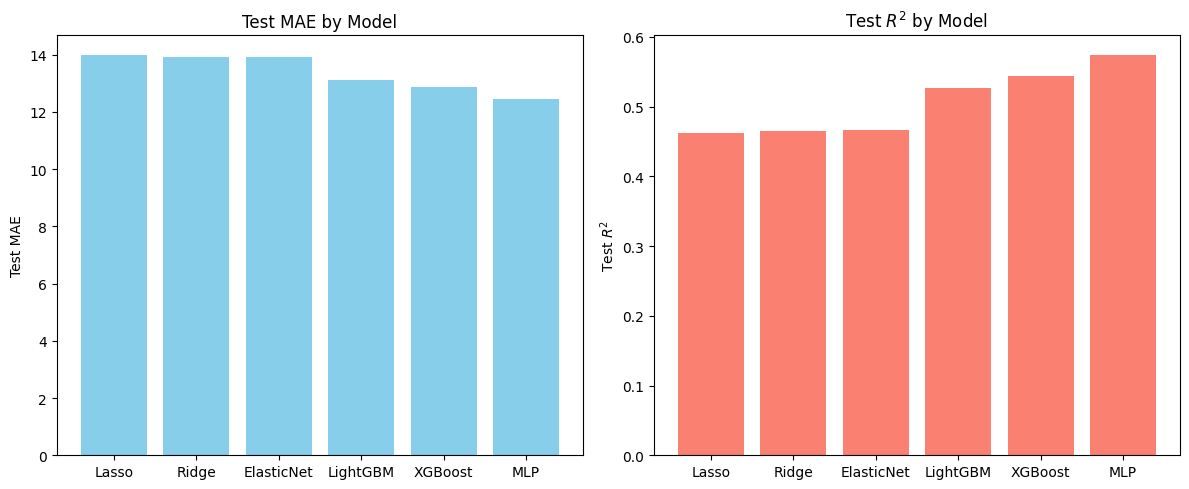

In [24]:
model_names = list(results.keys())
mae_scores = [100 * results[model]['test_mae'] for model in model_names] # Rescale IWI back to [0, 100]
r2_scores = [results[model]['test_r2'] for model in model_names]

plt.figure(figsize=(12, 5))

# Plot MAE scores
plt.subplot(1, 2, 1)
plt.bar(model_names, mae_scores, color='skyblue')
plt.ylabel("Test MAE")
plt.title("Test MAE by Model")

# Plot R^2 scores
plt.subplot(1, 2, 2)
plt.bar(model_names, r2_scores, color='salmon')
plt.ylabel(r"Test $R^2$")
plt.title(r"Test $R^2$ by Model")

plt.tight_layout()
plt.show()